Enter the coordinate limit (e.g., 200):  200
Enter the number of computers (e.g., 10):  4
Enter the number of nodes (e.g., 500):  200


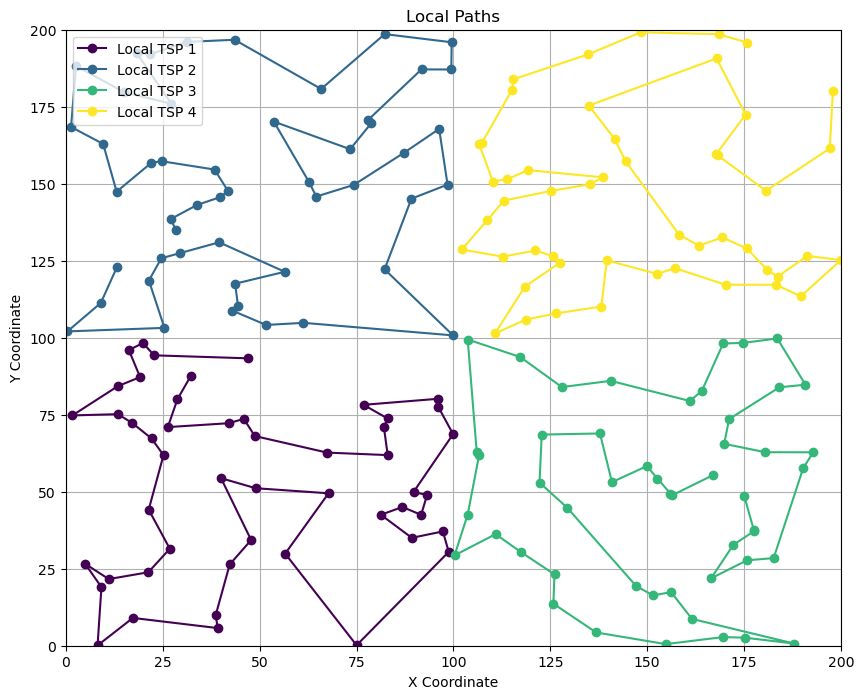

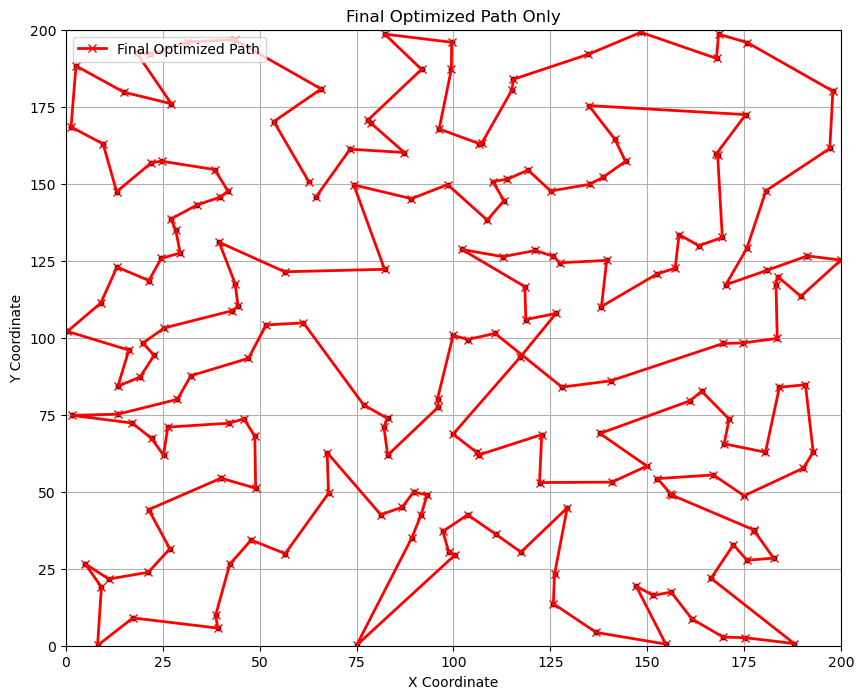

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from python_tsp.heuristics import solve_tsp_simulated_annealing
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

# Get user inputs for the coordinate limit, number of computers, and number of nodes
coordinate = int(input("Enter the coordinate limit (e.g., 200): "))
computers = int(input("Enter the number of computers (e.g., 10): "))
nodes = int(input("Enter the number of nodes (e.g., 500): "))

# Function to generate random node coordinates within specified limits
def generate_nodes():
    full_coordinates = np.empty((0, 2), float)
    x_section_arr = np.linspace(0, coordinate, 3)
    y_section_arr = np.linspace(0, coordinate, num=int(3 + ceil((computers - 4) / 2)))

    nodes_per_computer = max(1, nodes // computers)  # Ensure at least 1 node per computer
    for x_section in range(len(x_section_arr) - 1):
        for y_section in range(len(y_section_arr) - 1):
            x_nodes_coord = np.random.uniform(
                int(x_section_arr[x_section]),
                int(x_section_arr[x_section + 1]),
                size=(nodes_per_computer, 1)
            )
            y_nodes_coord = np.random.uniform(
                int(y_section_arr[y_section]),
                int(y_section_arr[y_section + 1]),
                size=(nodes_per_computer, 1)
            )
            col = np.column_stack((x_nodes_coord, y_nodes_coord))
            full_coordinates = np.append(full_coordinates, col, axis=0)

    return full_coordinates

# Function to calculate the distance matrix
def calcute_distance(arr):
    return squareform(pdist(arr, metric='euclidean'))

# Function for optimizing the individual paths
def optimize_local_paths(full_coordinates):
    local_paths = []
    for coords in full_coordinates:
        distance_matrix = calcute_distance(coords)
        permutation, _ = solve_tsp_simulated_annealing(distance_matrix)
        local_paths.append(coords[permutation])
    return local_paths

# Function to extract edges from local paths
def extract_edges(local_paths):
    edges = set()
    for path in local_paths:
        for i in range(len(path) - 1):
            edges.add((tuple(path[i]), tuple(path[i + 1])))
    return edges

# Function to create a complete distance matrix considering local TSP edges
def create_distance_matrix_with_edges(local_paths):
    edges = extract_edges(local_paths)

    # Create a unique list of nodes
    nodes = set()
    for edge in edges:
        nodes.update(edge)
    
    nodes = list(nodes)  # Convert to a list for indexing
    node_index = {node: idx for idx, node in enumerate(nodes)}  # Create indices for nodes
    
    # Initialize distance matrix
    num_nodes = len(nodes)
    distance_matrix = np.full((num_nodes, num_nodes), np.inf)  # Start with infinities
    
    # Add edges distances
    for edge in edges:
        i = node_index[edge[0]]
        j = node_index[edge[1]]
        dist = np.linalg.norm(np.array(edge[0]) - np.array(edge[1]))  # Euclidean distance
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist  # Symmetric

    # Fill in distances for all nodes not yet connected to create a complete graph
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if distance_matrix[i, j] == np.inf:
                dist = np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j]))
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist

    return distance_matrix, nodes

# Function to optimize the final path using graph edges from local paths
def optimize_final_path_with_local_edges(local_paths):
    # Create a distance matrix based on edges from local paths
    distance_matrix, nodes = create_distance_matrix_with_edges(local_paths)

    # Solve TSP for the nodes using simulated annealing
    permutation, _ = solve_tsp_simulated_annealing(distance_matrix)

    # Create final path based on TSP order of nodes
    final_path = np.array(nodes)[permutation]

    return final_path

# Function to plot local paths
def plot_paths(local_paths, all_coordinates, title='Local Paths'):
    plt.figure(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(local_paths)))

    for i, path in enumerate(local_paths):
        plt.plot(path[:, 0], path[:, 1], marker='o', color=colors[i], label=f'Local TSP {i + 1}')

    plt.scatter(all_coordinates[:, 0], all_coordinates[:, 1], color='black', s=10)
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left')
    plt.xlim(0, coordinate)
    plt.ylim(0, coordinate)
    plt.grid(True)
    plt.show()

# Function to plot the final optimized path
def plot_final_path(final_path, all_coordinates):
    plt.figure(figsize=(10, 8))
    plt.plot(final_path[:, 0], final_path[:, 1], marker='x', color='red', linewidth=2, label='Final Optimized Path')
    plt.scatter(all_coordinates[:, 0], all_coordinates[:, 1], color='black', s=10)
    plt.title('Final Optimized Path Only')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, coordinate)
    plt.ylim(0, coordinate)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Function to plot local and final paths together
def plot_paths_final(local_paths, final_path, all_coordinates):
    plt.figure(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(local_paths)))

    # Plot local TSPs
    for i, path in enumerate(local_paths):
        plt.plot(path[:, 0], path[:, 1], marker='o', color=colors[i], label=f'Local TSP {i + 1}')

    # Plot final combined TSP
    plt.plot(final_path[:, 0], final_path[:, 1], marker='x', color='red', linewidth=2, label='Final Optimized Path')

    # Label nodes
    plt.scatter(all_coordinates[:, 0], all_coordinates[:, 1], color='black', s=10)
    plt.title('Local and Final Optimized Paths')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left')
    plt.xlim(0, coordinate)
    plt.ylim(0, coordinate)
    plt.grid(True)
    plt.show()

# Function to compute the Minimum Spanning Tree
def compute_mst(all_coordinates):
    distance_matrix = calcute_distance(all_coordinates)
    mst = minimum_spanning_tree(distance_matrix)
    return mst.toarray().astype(float)

# Function to plot the Final Path with its MST
def plot_final_path_with_mst(final_path, all_coordinates, mst):
    plt.figure(figsize=(10, 8))
    plt.plot(final_path[:, 0], final_path[:, 1], marker='o', color='red', linewidth=2, label='Final Optimized Path')
    
    # Plot MST
    for i, j in zip(*np.nonzero(mst)):
        plt.plot(*zip(final_path[i], final_path[j]), color='blue', linewidth=0.5, alpha=0.7)

    plt.scatter(all_coordinates[:, 0], all_coordinates[:, 1], color='black', s=10)
    plt.title('Final Optimized Path and MST')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left')
    plt.xlim(0, coordinate)
    plt.ylim(0, coordinate)
    plt.grid(True)
    plt.show()

# Main execution block
if __name__ == '__main__':
    all_coordinates = generate_nodes()
    full_coordinates = np.array_split(all_coordinates, computers)

    # Optimize local paths for each computer
    local_paths = optimize_local_paths(full_coordinates)

    # Optimize the final path using existing edges from local TSPs
    final_path = optimize_final_path_with_local_edges(local_paths)

    # Compute the MST of all coordinates (optional)
    mst = compute_mst(all_coordinates)

    # Compute the MST specifically for the final path
    final_mst = compute_mst(final_path)

    # Plot all local paths
    plot_paths(local_paths, all_coordinates)

    # Plot final optimized path
    plot_final_path(final_path, all_coordinates)
